In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Introducing the stars
import tensorflow as tf
from tensorflow import keras

In [ ]:
print(tf.__version__, keras.__version__)
print(tf.config.list_physical_devices())

# Artificial Neural Networks

We will explore some basic usages of the `keras` package to build and train ANNs.

There are a few different ways in which `keras` can build ANN models. In particular, we will see the Sequential and Functional APIs. For feed-forward fully-connected networks, the Sequential API is probably the more straightforward.

## Neural Netwoks as good approximators

We will build a model to perform the simple task of approximating a 1-D real function.

### Using the Sequential API

In [ ]:
# Instatiate model
model = keras.models.Sequential()

# Use add method to add an input layer (which is also a keras class)
model.add(keras.layers.InputLayer(input_shape=(1,)))

# Add two fully-connected (a.k.a. Dense) hidden layers
# you can change the activation funtion
model.add(keras.layers.Dense(5, activation='tanh'))
model.add(keras.layers.Dense(4, activation='tanh'))

# Add the output layer. As this is a regression problem, choose linear activation
model.add(keras.layers.Dense(1, activation='linear'))

Now use `summary` method to see a description of what we just built

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Compilation

For the model to run, we must first compile it.

At this point, two crucial pieces of information have to be provided:
1. The error function (a.k.a. loss function)
2. The optimizer function.

In [ ]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=0.1))

### Data preparation

Let us put our model at test with a simple function.

In [ ]:
x = np.linspace(-1, 1, 100)

# Modulo
t = np.abs(x)

# Heavyside
# t = np.where(x > 0, 1, 0)

plt.plot(x, t, '.')

### Training

We are now ready to fit the model.

In its simplest form, the `fit` method takes the input vector `x` (here 1-d) and the label `t` (here 1-d). It also needs a number of `epochs` or steps to perform in the direction of the gradient. 

**N.B.** In fact, this is the number of times the gradient is evaluated using all data points, but the Stochastic Gradient Descent actually updates the parameter vector for each data batch. Its size can also be provided as an argument to the `fit` method.

In [ ]:
model.fit?

In [ ]:
model.fit(x, t, batch_size=int(len(x)/2), epochs=250)

### Prediction

In [ ]:
y = model.predict(x)
plt.plot(x, t)
plt.plot(x, y, 'o')

### Under the hood

In this simple network, we can see how things work. Let us get the weights for each layer.

In [ ]:
w1, w0 = model.layers[0].get_weights()
w2, z0 = model.layers[1].get_weights()
w3, z1 = model.layers[2].get_weights()

The weights are matrices whose size is related to the size of the layer and the number of units it connects.
The second argument is an array with the weights.

In [ ]:
print(w2.shape, z0.shape)
print(w2, z0)

With all this information, we can compute the outcome of the first layer, for each point in the dataset.

In [ ]:
def acti(x):
    return np.tanh(x)

In [ ]:
zz = []
for i in range(len(w1[0])):
  zz.append(acti(w1[0][i] * x + w0[i]))
  
    # xx = w1[0][i] * x + w0[i]
  # yy.append(np.where(xx > 0, xx, 0))

zz = np.array(zz).T
print(zz.shape)

In [ ]:
# Compute outcome of second layer
yy = acti(np.dot(zz, w2) + z0)

In [ ]:
# The final outcome is the combination of each of this four functions, with a weight...
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(x, t, lw=3, label='Ground truth')
for i, yi in enumerate(yy.T):
  ax.plot(x, yi * w3[i] + z1, '--', label='Unit {}'.format(i+1))

ax.plot(x, np.dot(yy, w3) + z1, label='Full result', lw=4, alpha=0.5)
ax.legend(loc=0)

# ANNs take on MNIST

We are going to use the MNIST dataset of handwritten numbers and train a simple neural network to classify them. This is a classical Machine Learning dataset.

The goal is then to try to understand how the network works, so we are going to choose a relatively simple architecture.

### Preparing the data

In [118]:
(X_train, t_train), (X_test, t_test) = keras.datasets.mnist.load_data()

The labels in `t_train` and `t_test` are numbers between 0 and 9.

The first thing we do is convert the class labels to 1-of-K encoding. For that we use the function `keras.utils.to_categorical` (similar to `sklearn`'s `OneHotEncoder`)

In [120]:
from tensorflow.keras.utils import to_categorical
t_train_ohe = to_categorical(t_train)
t_test_ohe = to_categorical(t_test)
print(t_train_ohe[:3], t_train[:3])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


Next, we normalise the images. We bring the pixel scale, originally between 0 and 255 to the interval [0, 1).

In [121]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

X_train = X_train/255.0
X_test = X_test/255.0

print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0 255
0 255
0.0 1.0
0.0 1.0


There is not much more to do in terms of data preparation, because `keras` already splits the set in train and test sets (which we will use as validation). 

Let us simply visualize some individuals.

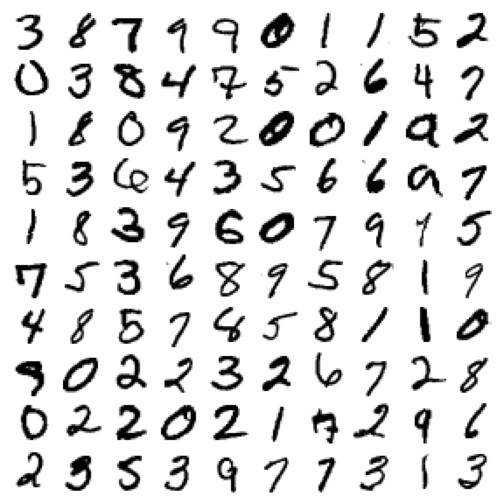

In [122]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap ='binary', **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
plot_digits(X_train[10000:10100], images_per_row=10)

### Model definition.

How do we start?

Let's take some ideas from the source of all knowledge: YouTube

In [57]:
from IPython.display import YouTubeVideo

YouTubeVideo('aircAruvnKk?start=332', width=1028, height=600)

<text font-size=56> dsadasd </text>

Good. Now implement a similar network.

* You can use inspiration from the video above, but be creative.
* What activations will you use?
* What kind of output layer do we need?

Complete the code below.

In [123]:
model = keras.models.Sequential()

# Input layer
model.add(keras.layers.Flatten(input_shape=(28,28)))

# Twi hidden layers with 32 units each
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))

# Output layer. As this is a multi-class classification problem, use K (here 10) units.
model.add(keras.layers.Dense(10, activation='softmax'))

### Compilation

Next comes compilation. 

* What loss function do we need for this dataset?
* What metrics shall be monitor?

In [128]:
# Uncomment and complete
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy', ])

***
**Small game**: Can you compute the number of parameters in this model?

In [129]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


### Training

To accelerate the process, and check that the network is not overfitting, we advise using early stopping.

In [130]:
# Uncomment and complete
early = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',
                                      restore_best_weights=True)

We know fit the model

In [131]:
# Uncomment and complete
history = model.fit(X_train, t_train_ohe, epochs=200, batch_size=32, validation_data=(X_test, t_test_ohe),
                    callbacks=[early, ])

Epoch 1/200
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7442 - accuracy: 0.7932 - val_loss: 0.3529 - val_accuracy: 0.8980
Epoch 2/200
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.9065 - val_loss: 0.2852 - val_accuracy: 0.9185
Epoch 3/200
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2696 - accuracy: 0.9225 - val_loss: 0.2364 - val_accuracy: 0.9328
Epoch 4/200
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2365 - accuracy: 0.9328 - val_loss: 0.2165 - val_accuracy: 0.9367
Epoch 5/200
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2133 - accuracy: 0.9397 - val_loss: 0.1999 - val_accuracy: 0.9433
Epoch 6/200
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1958 - accuracy: 0.9442 - val_loss: 0.1828 - val_accuracy: 0.9487
Epoch 7/200
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1819 - accuracy: 0.9480 - val_loss: 0.1773 - val_ac

Use the code below to make a plot of the evolution of the training.

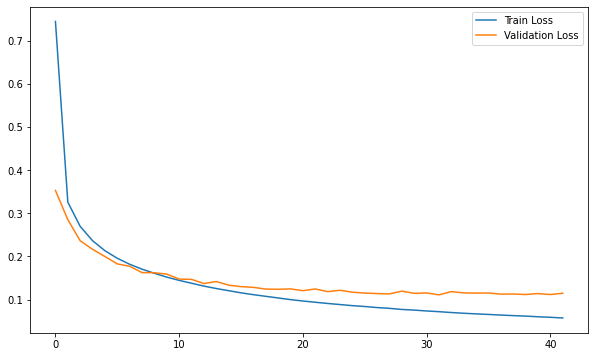

In [134]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc=0)

### Analysis

Exploremos ahora un poco más los errores de la red. Para eso, trabajaremos con el conjunto de test (esto no es del todo correcto porque usé el mismo conjunto para hacer la validación).

In [135]:
model.evaluate(X_test, t_test_ohe)

313/313 [==============================] - 1s 2ms/step - loss: 0.1112 - accuracy: 0.9673


[0.11116626858711243, 0.9672999978065491]

Let us take a closer look at the cases in which the network made mistakes

In [136]:
model.predict(X_test).shape

(10000, 10)

In [137]:
# Compute predictions and find instances with error
y_test = np.argmax(model.predict(X_test), axis=1)

# Find errors
ierror = (y_test - t_test != 0)

# How many are there
print('There are {} errors in the validation set'.format(np.sum(ierror)))

There are 327 errors in the validation set


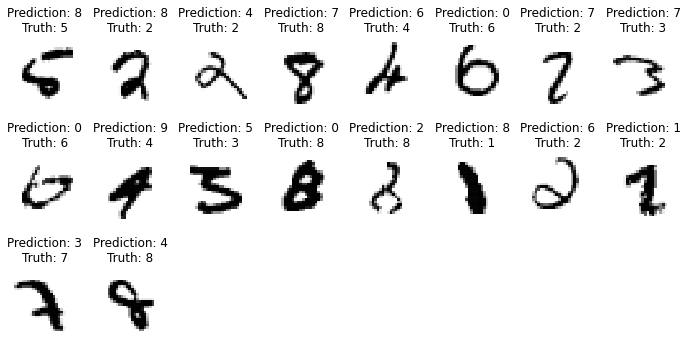

In [138]:
n_images = 18
n_columns = 8

n_rows = np.int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))
# Veamos algunos ejemplos de los datos en los que se equivocó

for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ierror][i], interpolation='None', cmap='binary')
    ax.set_title('Prediction: {}\nTruth: {}'.format(y_test[ierror][i], t_test[ierror][i]))

for ax in axs.flatten():
    ax.axis('off')

Ok, this seems reasonable, right? I mean, look at those numbers. Some are really tough....

Let's look at the probability distribution. I keep the probability of the class that was chosen by the network, both in the case of errors and those that were not.

In [139]:
pred_proba_all = np.max(model.predict(X_test), axis=1)

pred_proba = np.max(model.predict(X_test[~ierror]), axis=1)
pred_proba_err = np.max(model.predict(X_test[ierror]), axis=1)

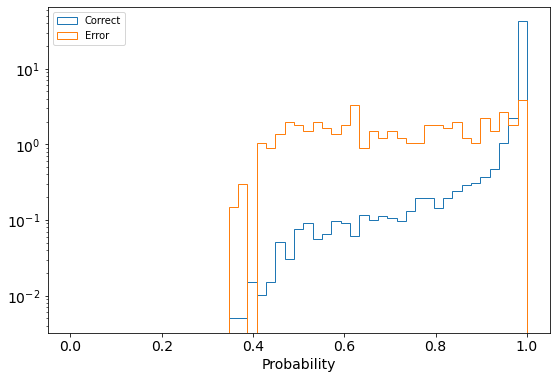

In [140]:
# Veamos la distribución
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0, 1, 50)
plt.hist(pred_proba, bins=bins, histtype='step', label='Correct', density=True, log=True)
plt.hist(pred_proba_err, bins=bins, histtype='step', label='Error', density=True)

# Labels and ticks
plt.xlabel('Probability', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)

This is good. The network seems to be less sure when making mistakes. This means we could tweak the decision threshold a bit to improve the performance.

But it seems to be quite sure of cases in which it makes mistakes. Let's see those.

In [141]:
ii = (pred_proba_all > 0.95) * (y_test - t_test != 0)

print('There are {} images mistakenly classified with over 95% probability'.format(sum(ii)))

There are 45 images mistakenly classified with over 95% probability


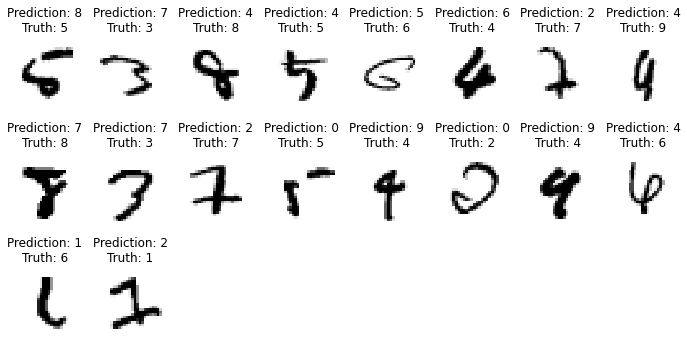

In [142]:
n_images = 18
n_columns = 8

n_rows = np.int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))
# Veamos algunos ejemplos de los datos en los que se equivocó

for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ii][i], interpolation='None', cmap='binary')
    ax.set_title('Prediction: {}\nTruth: {}'.format(y_test[ii][i], 
                                                    t_test[ii][i]))

for ax in axs.flatten():
    ax.axis('off')

#### How does the network learn.

Let's try to look inside the network to understand if he understood something about what numbers are like or not. There are many parameters, but we are hopeful that at least the first layer is something reasonable, like an edge detector. Let's see.

Let's read the weights and bias of the first hidden layer and see the shapes.

In [143]:
# Note here the relevant layer is layer[1], as layer[0] is a flattening layer.
W, b = model.layers[1].get_weights()
print(W.shape, b.shape)

(784, 32) (32,)


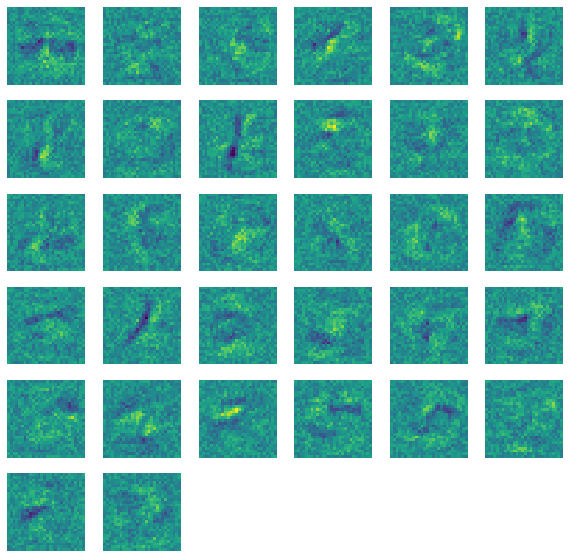

In [144]:
WW = W.reshape([28,28,32])

# Find relavant limits for pixel values
Wmin = WW[3:-3, 3:-3].min()
Wmax = WW[3:-3, 3:-3].max()

fig = plt.figure(figsize=(10,10))
for i in range(WW.shape[-1]):
    ax = fig.add_subplot(6, 6, i+1)
    #  ax.imshow(WW[2:-2, 2:-2, i], interpolation='None')
    # Fixed limits in Z axis
    
    ax.imshow(WW[:, :, i], interpolation='None', vmin=Wmin, vmax=Wmax)
    ax.axis('off')

The weights of the first layer do not look at all like border detectors, or anything like that. 

It seems the network finds a much stranger way to generalise than we would do. We will see that CNNs do something much closer to what one would expect.

**Does this make sense?**

* We never provided any idea of neighbourhood between features. How could the network tell?
* How can we generate a neural network that recognizes images in a more similar way to how humans do?

This is the topic of the week after the next...

# Regression example: California Housing

Just to show you the pipeline, here's an example of a regression task. We'll use the same California Housing dataset that we used in our firsts classes.

Here we import the model, split the dataset into training, validation and test sets, and standarize it.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

We'll define a simple model, with a single hidden layer, and no activation function in the last layer

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

We fit the model

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

And we evaluate on the test set

In [ ]:
mse_test = model.evaluate(X_test, y_test)

And give predictions on new data

In [ ]:
X_new = X_test[:3]
y_pred = model.predict(X_new)
print(y_pred)